In [1]:
import os
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta

# === ETF list (excluding XLC, JETS)
etf_list = [
    'XLK', 'XLF', 'XLV', 'XLE', 'XLI', 'XLY', 'XLP', 'XLU', 'XLB',
    'SOXX', 'SH', 'DOG', 'RWM', 'ITA', 'PSQ', 'VNQ', 'SPY', 'QQQ'
]

# === Date range: 20 years
today = datetime.today()
start_date = (today - timedelta(weeks=52 * 20)).strftime('%Y-%m-%d')
end_date = today.strftime('%Y-%m-%d')
print(f"🗕️ Downloading weekly data from {start_date} to {end_date} (until last Friday)")

# === Output folder
dataset_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset'))
os.makedirs(dataset_path, exist_ok=True)

# === Containers
adjclose_data, volume_data, high_data, low_data = {}, {}, {}, {}

# === Align to next Friday
def shift_to_next_friday(date):
    weekday = date.weekday()
    days_until_friday = (4 - weekday + 7) % 7
    return date + timedelta(days=days_until_friday)

# === Download ETF weekly data
for symbol in etf_list:
    print(f"⬇️ Downloading {symbol}...")
    data = yf.download(
        symbol,
        start=start_date,
        end=end_date,
        interval='1wk',
        auto_adjust=False,
        progress=False
    )
    if not data.empty:
        data = data[~data.index.duplicated(keep='first')].sort_index()
        data.index = data.index.to_series().apply(shift_to_next_friday)
        data = data[data.index <= pd.Timestamp(today.date())]

        adjclose_data[symbol] = data[['Adj Close']].rename(columns={'Adj Close': symbol})
        volume_data[symbol] = data[['Volume']].rename(columns={'Volume': symbol})
        high_data[symbol] = data[['High']].rename(columns={'High': symbol})
        low_data[symbol] = data[['Low']].rename(columns={'Low': symbol})

# === Save function
def combine_and_save(data_dict, filename):
    df = pd.concat(data_dict.values(), axis=1)
    df.index = pd.to_datetime(df.index, errors='coerce')
    df = df[df.index < pd.Timestamp(today.date())]
    df = df[~df.index.duplicated(keep='first')].sort_index()
    df.dropna(axis=0, how='all', inplace=True)
    df.insert(0, 'Date', df.index.strftime('%Y-%m-%d'))
    df.to_csv(os.path.join(dataset_path, filename), index=False)
    print(f"✅ Saved: {filename}")
    return df

# === Save all
price_df = combine_and_save(adjclose_data, 'etf_prices_weekly.csv')
volume_df = combine_and_save(volume_data, 'etf_volume_weekly.csv')
high_df = combine_and_save(high_data, 'etf_high_weekly.csv')
low_df = combine_and_save(low_data, 'etf_low_weekly.csv')

# === Preview
price_df.head()


🗕️ Downloading weekly data from 2005-05-22 to 2025-04-27 (until last Friday)
⬇️ Downloading XLK...
⬇️ Downloading XLF...
⬇️ Downloading XLV...
⬇️ Downloading XLE...
⬇️ Downloading XLI...
⬇️ Downloading XLY...
⬇️ Downloading XLP...
⬇️ Downloading XLU...
⬇️ Downloading XLB...
⬇️ Downloading SOXX...
⬇️ Downloading SH...
⬇️ Downloading DOG...
⬇️ Downloading RWM...
⬇️ Downloading ITA...
⬇️ Downloading PSQ...
⬇️ Downloading VNQ...
⬇️ Downloading SPY...
⬇️ Downloading QQQ...
✅ Saved: etf_prices_weekly.csv
✅ Saved: etf_volume_weekly.csv
✅ Saved: etf_high_weekly.csv
✅ Saved: etf_low_weekly.csv


Price,Date,XLK,XLF,XLV,XLE,XLI,XLY,XLP,XLU,XLB,SOXX,SH,DOG,RWM,ITA,PSQ,VNQ,SPY,QQQ
Ticker,,XLK,XLF,XLV,XLE,XLI,XLY,XLP,XLU,XLB,SOXX,SH,DOG,RWM,ITA,PSQ,VNQ,SPY,QQQ
Date,,,,,,,,,,,,,,,,,,,
2005-05-27,2005-05-27,15.652975,15.888412,22.373449,23.806690,20.594004,25.691679,13.896779,14.984303,18.030703,14.775471,NaN,NaN,NaN,NaN,NaN,23.835028,82.605659,32.711491
2005-06-03,2005-06-03,15.606737,15.861331,22.280787,24.163794,20.519310,25.652857,13.867079,15.203782,18.075731,14.943595,NaN,NaN,NaN,NaN,NaN,24.280741,82.536926,32.617294
2005-06-10,2005-06-10,15.545068,15.899248,22.181011,24.741951,20.471777,25.722738,13.884897,15.323499,18.095032,14.888477,NaN,NaN,NaN,NaN,NaN,24.747677,82.571289,32.146439
2005-06-17,2005-06-17,15.645267,16.050928,22.565895,25.983305,20.614361,26.157530,13.843312,15.398310,18.526024,14.910520,NaN,NaN,NaN,NaN,NaN,25.431107,83.368179,32.420399
2005-06-24,2005-06-24,15.406356,15.971840,22.234291,25.552778,19.937368,25.534819,13.575711,15.649825,17.672993,14.772718,NaN,NaN,NaN,NaN,NaN,25.015104,82.063126,31.679171


In [2]:
import os 
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# === Macro indicator tickers ===
macro_tickers = {
    'VIX': '^VIX',
    '10Y_Yield': '^TNX',   # Scale * 0.1
    '2Y_Yield': '^IRX',    # Scale * 0.01
    'USD_Index': 'DX-Y.NYB',
    'WTI_Crude': 'CL=F',

}

# === Date range ===
today = datetime.today()
back_time = today - timedelta(weeks=52 * 20)
start_date = back_time.strftime('%Y-%m-%d')
end_date = today.strftime('%Y-%m-%d')

print(f"📊 Downloading macro indicators from {start_date} to {end_date}")

# === Output path ===
macro_save_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'macro_indicators_weekly.csv'))

# === Shift helper ===
def shift_to_next_friday(date):
    days_ahead = (4 - date.weekday() + 7) % 7
    return date + timedelta(days=days_ahead)

# === Download each macro ticker ===
macro_data = {}
for name, ticker in macro_tickers.items():
    print(f"⬇️ Downloading {name} ({ticker})...")
    data = yf.download(ticker, start=start_date, end=end_date, interval='1wk', auto_adjust=False, progress=False)
    if not data.empty:
        data = data[~data.index.duplicated(keep='first')].sort_index()
        data.index = pd.to_datetime([shift_to_next_friday(d) for d in data.index])
        #filter futrue data
        data = data[data.index < pd.Timestamp(today.date())]
        macro_data[name] = data[['Close']].rename(columns={'Close': name})

# === Combine into single DataFrame ===
macro_df = pd.concat(macro_data.values(), axis=1)
macro_df.index = pd.to_datetime(macro_df.index)
macro_df = macro_df[~macro_df.index.duplicated(keep='first')].sort_index()

# === Apply scaling to yields ===
if '10Y_Yield' in macro_df.columns:
    macro_df['10Y_Yield'] *= 0.1
if '2Y_Yield' in macro_df.columns:
    macro_df['2Y_Yield'] *= 0.01

# === Final cleanup ===
macro_df.dropna(axis=0, how='all', inplace=True)
macro_df.insert(0, 'Date', macro_df.index.strftime('%Y-%m-%d'))
macro_df.to_csv(macro_save_path, index=False)

print(f"✅ Macro indicators saved to: {macro_save_path}")


📊 Downloading macro indicators from 2005-05-22 to 2025-04-27
⬇️ Downloading VIX (^VIX)...
⬇️ Downloading 10Y_Yield (^TNX)...
⬇️ Downloading 2Y_Yield (^IRX)...
⬇️ Downloading USD_Index (DX-Y.NYB)...
⬇️ Downloading WTI_Crude (CL=F)...
✅ Macro indicators saved to: D:\CodingWorks\Weekly_Swing_TransformerQT\dataset\macro_indicators_weekly.csv


In [3]:
# calculate TA signals


import os
import pandas as pd
from ta import momentum, trend, volume

# === Paths ===
price_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'etf_prices_weekly.csv'))
volume_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'etf_volume_weekly.csv'))

# === Helper to load ETF CSVs ===
def load_etf_csv(path, name='[unknown]'):
    try:
        header_row = pd.read_csv(path, header=None, nrows=2)
        columns = header_row.iloc[1].tolist()[1:]
        df = pd.read_csv(path, skiprows=3, header=None)
        df = df.iloc[:, :len(columns) + 1]
        df.columns = ['Date'] + columns
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.set_index('Date')
        df = df.apply(pd.to_numeric, errors='coerce')
        print(f"✅ Loaded {name} with {len(columns)} tickers")
        return df
    except Exception as e:
        print(f"❌ Failed to load {name}: {e}")
        raise

# === Load data ===
price_df = load_etf_csv(price_path, name='ETF Prices')
volume_df = load_etf_csv(volume_path, name='ETF Volume')

# === Feature storage ===
features_all = []
skipped = []

# === Feature generation loop ===
for symbol in price_df.columns:
    if symbol not in volume_df.columns:
        print(f"⚠️ Skipping {symbol}: volume data missing.")
        skipped.append(symbol)
        continue

    df = pd.DataFrame(index=price_df.index)
    df['close'] = price_df[symbol]
    df['volume'] = volume_df[symbol]

    try:
        # === Return-based technical indicators ===
        df[f'{symbol}_ret_1w'] = df['close'].pct_change(1)
        df[f'{symbol}_ret_3w'] = df['close'].pct_change(3)
        df[f'{symbol}_ret_6w'] = df['close'].pct_change(6)

        high = df['close'].rolling(window=14).max()
        low = df['close'].rolling(window=14).min()
        df[f'{symbol}_stoch_k'] = 100 * (df['close'] - low) / (high - low)
        df[f'{symbol}_stoch_d'] = df[f'{symbol}_stoch_k'].rolling(window=3).mean()
        df[f'{symbol}_williams_r'] = -100 * (high - df['close']) / (high - low)

        df[f'{symbol}_cci'] = trend.cci(high=df['close'], low=df['close'], close=df['close'], window=20)
        df[f'{symbol}_rsi'] = momentum.rsi(df['close'], window=14)
        df[f'{symbol}_obv'] = volume.on_balance_volume(df['close'], df['volume'])

        df[f'{symbol}_macd'] = trend.macd(df['close'])
        df[f'{symbol}_macd_signal'] = trend.macd_signal(df['close'])
        df[f'{symbol}_macd_diff'] = trend.macd_diff(df['close'])

        # === Short-term KST (custom) ===
        roc1 = df['close'].pct_change(10)
        roc2 = df['close'].pct_change(15)
        roc3 = df['close'].pct_change(20)
        roc4 = df['close'].pct_change(30)
        df[f'{symbol}_kst_short'] = (
            roc1.rolling(10).mean() +
            roc2.rolling(10).mean() * 2 +
            roc3.rolling(10).mean() * 3 +
            roc4.rolling(15).mean() * 4
        )

        derived_cols = df.columns.difference(['close', 'volume'])
        feature_df = df[derived_cols].copy()

        features_all.append(feature_df)
        print(f"📈 {symbol}: {feature_df.dropna(how='all').shape[0]} valid rows")

    except Exception as e:
        print(f"❌ Error processing {symbol}: {e}")
        skipped.append(symbol)

# === Final merge ===
if len(features_all) == 0:
    raise ValueError("🛑 No valid ETF features generated.")

features_df = pd.concat(features_all, axis=1).sort_index()
features_df = features_df[~features_df.index.duplicated(keep='first')]

print("📀 Final feature shape:", features_df.shape)

# === Save to CSV ===
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset'))
features_df.to_csv(os.path.join(base_dir, 'weekly_etf_tech_feature.csv'))
print(f"✅ Saved features to: weekly_etf_tech_feature.csv")


✅ Loaded ETF Prices with 18 tickers
✅ Loaded ETF Volume with 18 tickers
📈 XLK: 1039 valid rows
📈 XLF: 1039 valid rows
📈 XLV: 1039 valid rows
📈 XLE: 1039 valid rows
📈 XLI: 1039 valid rows
📈 XLY: 1039 valid rows
📈 XLP: 1039 valid rows
📈 XLU: 1039 valid rows
📈 XLB: 1039 valid rows
📈 SOXX: 1039 valid rows
📈 SH: 1026 valid rows
📈 DOG: 1026 valid rows
📈 RWM: 1026 valid rows
📈 ITA: 1026 valid rows
📈 PSQ: 1026 valid rows
📈 VNQ: 1039 valid rows
📈 SPY: 1039 valid rows
📈 QQQ: 1039 valid rows
📀 Final feature shape: (1039, 234)
✅ Saved features to: weekly_etf_tech_feature.csv


In [4]:
# normalizing matrix add masks


# Normalize and mask using consistent CSV structure
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Paths ===
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset'))
feat_path = os.path.join(base_dir, 'weekly_etf_tech_feature.csv')
macro_path = os.path.join(base_dir, 'macro_indicators_weekly.csv')
price_path = os.path.join(base_dir, 'etf_prices_weekly.csv')

# === Load Data ===
feat_df = pd.read_csv(feat_path)
macro_df = pd.read_csv(macro_path)
price_df = pd.read_csv(price_path)

# === Set Index ===
feat_df.set_index('Date', inplace=True)
macro_df.set_index('Date', inplace=True)
price_df.set_index('Date', inplace=True)

# === Convert index to datetime
today = pd.Timestamp.today().normalize()
feat_df.index = pd.to_datetime(feat_df.index)
macro_df.index = pd.to_datetime(macro_df.index)
price_df.index = pd.to_datetime(price_df.index)

feat_df = feat_df[feat_df.index < today]
macro_df = macro_df[macro_df.index < today]
price_df = price_df[price_df.index < today]

# === Drop duplicated rows if any
feat_df = feat_df[~feat_df.index.duplicated()]
macro_df = macro_df[~macro_df.index.duplicated()]
price_df = price_df[~price_df.index.duplicated()]

# === Output Directory ===
norm_dir = os.path.join(base_dir, 'normalized_matrix')
os.makedirs(norm_dir, exist_ok=True)

# === Scaler
scaler = StandardScaler()

# === Detect unique tickers
all_cols = feat_df.columns
tickers = sorted(set(col.split('_')[0] for col in all_cols if '_' in col))
print(f"🧾 Tickers detected: {tickers}")

for ticker in tickers:
    feat_cols = [c for c in feat_df.columns if c.startswith(f"{ticker}_")]
    if ticker not in price_df.columns:
        print(f"⚠️ Skipped {ticker}: no matching price data.")
        continue

    # Build DataFrame with date index
    df = pd.DataFrame(index=feat_df.index)

    # Add technical indicators
    for col in feat_cols:
        clean_name = col.replace(f"{ticker}_", "")
        df[clean_name] = feat_df[col]

    # Add price
    df.insert(0, 'price', price_df[ticker])

    # Add macro indicators
    df = df.join(macro_df, how='left')

    # Create mask before filling NAs
    mask = df.isna().astype(float)


    # Normalize technical (non-macro) features
    macro_cols = macro_df.columns
    norm_cols = df.columns.difference(macro_cols.union({'price'}))

    if df[norm_cols].dropna(how='all').empty:
        print(f"⚠️ Skipped {ticker}: no valid technical features.")
        continue

    df[norm_cols] = scaler.fit_transform(df[norm_cols].fillna(0.0))
    df[macro_cols] = df[macro_cols].fillna(0.0)

    # === Save
    df.to_csv(os.path.join(norm_dir, f'{ticker}_combined.csv'))
    mask.to_csv(os.path.join(norm_dir, f'{ticker}_mask.csv'))
    print(f"✅ Saved {ticker}: {df.shape[0]} rows, {df.shape[1]} features")


🧾 Tickers detected: ['DOG', 'ITA', 'PSQ', 'QQQ', 'RWM', 'SH', 'SOXX', 'SPY', 'VNQ', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
✅ Saved DOG: 1039 rows, 19 features
✅ Saved ITA: 1039 rows, 19 features
✅ Saved PSQ: 1039 rows, 19 features
✅ Saved QQQ: 1039 rows, 19 features
✅ Saved RWM: 1039 rows, 19 features
✅ Saved SH: 1039 rows, 19 features
✅ Saved SOXX: 1039 rows, 19 features
✅ Saved SPY: 1039 rows, 19 features
✅ Saved VNQ: 1039 rows, 19 features
✅ Saved XLB: 1039 rows, 19 features
✅ Saved XLE: 1039 rows, 19 features
✅ Saved XLF: 1039 rows, 19 features
✅ Saved XLI: 1039 rows, 19 features
✅ Saved XLK: 1039 rows, 19 features
✅ Saved XLP: 1039 rows, 19 features
✅ Saved XLU: 1039 rows, 19 features
✅ Saved XLV: 1039 rows, 19 features
✅ Saved XLY: 1039 rows, 19 features


In [5]:
# signal calculation

import os
import pandas as pd
import numpy as np

# === Setup Paths ===
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'normalized_matrix'))
output_path = os.path.join(data_dir, 'signal_distribution_8class.csv')

# === Signal Labels ===
signal_labels = [
    'strong down',  # 0
    'down',         # 1
    'slight down',  # 2
    'flat',         # 3
    'slight up',    # 4
    'up',           # 5
    'strong up',    # 6
    'inverse'       # 7
]

# === Classification Function ===
def classify_8class(ret_t, ret_t1):
    gap = abs(ret_t1 - ret_t)

    # Inverse only if direction flips AND movement is significant (≥ 1.0%)
    if ret_t < 0 and ret_t1 > 0.5 and gap >= 1.5:
        return 7  # inverse
    if ret_t > 0 and ret_t1 < -0.5 and gap >= 1.5:
        return 7  # inverse

    # Regular classification
    if ret_t1 <= -2.0:
        return 0  # strong down
    elif ret_t1 <= -1.2:
        return 1  # down
    elif ret_t1 <= -0.3:
        return 2  # slight down
    elif ret_t1 <= 0.3:
        return 3  # flat
    elif ret_t1 <= 1.2:
        return 4  # slight up
    elif ret_t1 <= 2.0:
        return 5  # up
    else:
        return 6  # strong up



# === Analyze Each ETF ===
etf_list = [f.replace('_combined.csv', '') for f in os.listdir(data_dir) if f.endswith('_combined.csv')]
records = []

for etf in etf_list:
    try:
        df = pd.read_csv(os.path.join(data_dir, f"{etf}_combined.csv"), index_col=0)
        df.index = pd.to_datetime(df.index)
        if 'ret_1w' not in df.columns:
            continue

        ret = df['ret_1w'].values
        count_vec = np.zeros(8, dtype=int)

        for i in range(len(ret) - 1):
            label = classify_8class(ret[i], ret[i+1])
            count_vec[label] += 1

        records.append([etf] + count_vec.tolist())

    except Exception as e:
        print(f"⚠️ Failed on {etf}: {e}")

# === Save CSV ===
df_out = pd.DataFrame(records, columns=['ETF'] + signal_labels)
df_out.to_csv(output_path, index=False)
print(f"✅ Saved signal distribution: {output_path}")


✅ Saved signal distribution: D:\CodingWorks\Weekly_Swing_TransformerQT\dataset\normalized_matrix\signal_distribution_8class.csv


# start training

In [12]:
# === CNN + BiLSTM + Attention Model Training (8-class with penalty) ===

import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from datetime import datetime

# === Paths ===
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'normalized_matrix'))
model_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'model_weights'))
signal_stat_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'normalized_matrix', 'signal_distribution_8class.csv'))
os.makedirs(model_dir, exist_ok=True)

# === Penalty Weights ===
penalty_strong = 1.0
penalty_medium = 0.4
penalty_slight = 0.1

# === Label Functions (8-class) ===

def class_to_group(cls):
    if cls in [0, 1, 2]: return 'down'
    if cls in [4, 5, 6]: return 'up'
    if cls == 3: return 'flat'
    if cls == 7: return 'inverse'

def class_to_magnitude(cls):
    if cls in [0, 6]: return 'strong'
    if cls in [1, 5]: return 'normal'
    if cls in [2, 4]: return 'slight'
    if cls == 3: return 'flat'
    if cls == 7: return 'inverse'

# === Dataset ===
class ETFDataset(Dataset):
    def __init__(self, combined_csv, mask_csv, return_feature="ret_1w", seq_len=8):
        df = pd.read_csv(combined_csv, index_col=0)
        mask = pd.read_csv(mask_csv, index_col=0)
        df.index = pd.to_datetime(df.index)
        mask.index = pd.to_datetime(mask.index)

        self.dates = df.index
        self.seq_len = seq_len
        self.raw_X = df.drop(columns=['price']).values.astype(np.float32)
        self.raw_M = mask.drop(columns=['price']).values.astype(np.float32)
        self.raw_y = df[return_feature].values.astype(np.float32)

        self.X, self.M, self.y = [], [], []
        for i in range(seq_len, len(self.raw_X) - 1):
            self.X.append(self.raw_X[i-seq_len:i+1])
            self.M.append(self.raw_M[i-seq_len:i+1])
            self.y.append((self.raw_y[i], self.raw_y[i + 1]))

        self.X = np.stack(self.X)
        self.M = np.stack(self.M)
        self.y = np.array(self.y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx]),
            torch.tensor(self.M[idx]),
            torch.tensor(self.y[idx])
        )

# === Model ===
class CNNBiLSTMAttnClassifier(nn.Module):
    def __init__(self, num_features, hidden_dim=128):
        super().__init__()
        self.cnn = nn.Conv1d(in_channels=num_features, out_channels=64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=64, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        self.attn_weights = nn.Linear(hidden_dim * 2, 1)
        self.output = nn.Linear(hidden_dim * 2, 8)

    def forward(self, x, mask):
        x = x * (1 - mask)
        x = x.permute(0, 2, 1)
        x = self.relu(self.cnn(x))
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        attn_scores = torch.softmax(self.attn_weights(lstm_out), dim=1)
        context = torch.sum(attn_scores * lstm_out, dim=1)
        return self.output(context)

# === Settings ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 0.001
max_epochs = 30
seq_len = 8

# === Clear all weights in model ===
def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

# === Train Loop with Penalty-aware Baseline ===
def train_one_etf(etf, signal_stat_df):
    print(f"\n🚀 Training {etf}")

    feat_path = os.path.join(data_dir, f"{etf}_combined.csv")
    mask_path = os.path.join(data_dir, f"{etf}_mask.csv")
    dataset = ETFDataset(feat_path, mask_path, seq_len=seq_len)

    # === Split: first 17 years train, last 3 years validate
    cutoff_date = dataset.dates[-1] - pd.DateOffset(years=3)
    split_idx = next(i for i, d in enumerate(dataset.dates[seq_len+1:]) if d > cutoff_date)
    train_set = torch.utils.data.Subset(dataset, range(0, split_idx))
    val_set = torch.utils.data.Subset(dataset, range(split_idx, len(dataset)))

    train_loader = DataLoader(train_set, batch_size=32, shuffle=False)
    val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

    # === Baseline: Class Entropy + Penalty
    dist_row = signal_stat_df[signal_stat_df['ETF'] == etf].iloc[0, 1:].astype(float).values
    prob = dist_row / np.sum(dist_row)
    entropy = -np.sum(prob * np.log(prob + 1e-8))

    # Simulated average penalty of a random model guessing per prob
    penalty_matrix = np.zeros((8, 8))
    for true_cls in range(8):
        for pred_cls in range(8):
            pg, tg = class_to_group(pred_cls), class_to_group(true_cls)
            pm, tm = class_to_magnitude(pred_cls), class_to_magnitude(true_cls)
            if tg == 'flat' and pg == 'inverse':
                penalty_matrix[true_cls][pred_cls] = penalty_strong
            elif tg != pg and 'inverse' in {pg, tg}:
                penalty_matrix[true_cls][pred_cls] = penalty_strong
            elif tg != pg and ('up' in {tg, pg} or 'down' in {tg, pg}) and 'flat' in {tg, pg}:
                penalty_matrix[true_cls][pred_cls] = penalty_medium
            elif tg == pg and tm != pm:
                penalty_matrix[true_cls][pred_cls] = penalty_slight

    penalty_baseline = 0.0
    for true_cls in range(8):
        for pred_cls in range(8):
            penalty_baseline += prob[true_cls] * prob[pred_cls] * penalty_matrix[true_cls][pred_cls]

    print(f"📊 {etf} Random Guess Loss (Entropy): {entropy:.4f} + Penalty: {penalty_baseline:.4f} = {entropy + penalty_baseline:.4f}")

    # === Build model
    X, _, _ = next(iter(train_loader))
    model = CNNBiLSTMAttnClassifier(num_features=X.shape[-1]).to(device)
    reset_weights(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    best_val_loss = float('inf')
    best_weights = None

    for epoch in range(max_epochs):
        model.train()
        total_loss = 0

        for X, M, y in train_loader:
            X, M, y = X.to(device), M.to(device), y.to(device)
            ret_t, ret_t1 = y[:, 0].cpu().numpy(), y[:, 1].cpu().numpy()
            true_class = torch.tensor([classify_8class(rt, rt1) for rt, rt1 in zip(ret_t, ret_t1)], device=device)

            logits = model(X, M)
            pred_class = logits.argmax(dim=1)

            ce_loss = criterion(logits, true_class)

            penalty = 0.0
            for p, t, rt, rt1 in zip(pred_class.cpu().tolist(), true_class.cpu().tolist(), ret_t, ret_t1):
                pg, tg = class_to_group(p), class_to_group(t)
                pm, tm = class_to_magnitude(p), class_to_magnitude(t)

                if tg == 'flat' and pg == 'inverse':
                    penalty += penalty_strong
                elif tg != pg and 'inverse' in {pg, tg}:
                    penalty += penalty_strong
                elif tg != pg and ('up' in {tg, pg} or 'down' in {tg, pg}) and 'flat' in {tg, pg}:
                    penalty += penalty_medium
                elif tg == pg and tm != pm:
                    penalty += penalty_slight

            loss = ce_loss + (penalty / len(true_class))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # === Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, M, y in val_loader:
                X, M, y = X.to(device), M.to(device), y.to(device)
                ret_t, ret_t1 = y[:, 0].cpu().numpy(), y[:, 1].cpu().numpy()
                true_class = torch.tensor([classify_8class(rt, rt1) for rt, rt1 in zip(ret_t, ret_t1)], device=device)
                logits = model(X, M)
                val_loss += criterion(logits, true_class).item()

        avg_loss = total_loss / len(train_loader)
        avg_val = val_loss / len(val_loader)

        if avg_val < best_val_loss:
            best_val_loss = avg_val
            best_weights = model.state_dict()

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1:03d} ▶️ Train Loss: {avg_loss:.4f} | Val Loss: {avg_val:.4f}")

    torch.save({'weights': best_weights, 'val_loss': best_val_loss},
               os.path.join(model_dir, f"{etf}_top1.pt"))


# === Load + Train All ETFs
signal_stat_df = pd.read_csv(signal_stat_path)
etf_list = signal_stat_df['ETF'].tolist()
for etf in etf_list:
    train_one_etf(etf, signal_stat_df)





🚀 Training DOG
📊 DOG Random Guess Loss (Entropy): 1.5731 + Penalty: 0.3898 = 1.9629
Epoch 005 ▶️ Train Loss: 1.8262 | Val Loss: 1.6090
Epoch 010 ▶️ Train Loss: 1.7739 | Val Loss: 1.5877
Epoch 015 ▶️ Train Loss: 1.7280 | Val Loss: 1.6538
Epoch 020 ▶️ Train Loss: 1.6510 | Val Loss: 1.6340
Epoch 025 ▶️ Train Loss: 1.6512 | Val Loss: 1.6026
Epoch 030 ▶️ Train Loss: 1.5892 | Val Loss: 1.7304

🚀 Training ITA
📊 ITA Random Guess Loss (Entropy): 1.5643 + Penalty: 0.3962 = 1.9605
Epoch 005 ▶️ Train Loss: 1.8709 | Val Loss: 1.5598
Epoch 010 ▶️ Train Loss: 1.8218 | Val Loss: 1.5129
Epoch 015 ▶️ Train Loss: 1.7623 | Val Loss: 1.4877
Epoch 020 ▶️ Train Loss: 1.7783 | Val Loss: 1.5077
Epoch 025 ▶️ Train Loss: 1.6946 | Val Loss: 1.5263
Epoch 030 ▶️ Train Loss: 1.6324 | Val Loss: 1.5440

🚀 Training JETS
📊 JETS Random Guess Loss (Entropy): 1.5609 + Penalty: 0.3556 = 1.9165
Epoch 005 ▶️ Train Loss: 1.8592 | Val Loss: 1.5368
Epoch 010 ▶️ Train Loss: 1.7489 | Val Loss: 1.4871
Epoch 015 ▶️ Train Loss: 1.68

In [13]:


# saving prediction (for 8-class CNN+BiLSTM model)

import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime

# === Paths ===
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'normalized_matrix'))
model_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'model_weights'))
output_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'predicted_vs_actual'))
os.makedirs(output_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 8-Class Labels
class_names = [
    "strong down",  # 0
    "down",         # 1
    "slight down",  # 2
    "flat",         # 3
    "slight up",    # 4
    "up",           # 5
    "strong up",    # 6
    "inverse"       # 7
]




# === ETF Prediction
etf_list = [f.replace('_combined.csv', '') for f in os.listdir(data_dir) if f.endswith('_combined.csv')]

print("📊 Generating predictions for 8-class model:")
for etf in tqdm(etf_list):
    try:
        feat_path = os.path.join(data_dir, f"{etf}_combined.csv")
        mask_path = os.path.join(data_dir, f"{etf}_mask.csv")
        model_path = os.path.join(model_dir, f"{etf}_top1.pt")

        df_feat = pd.read_csv(feat_path, index_col=0)
        df_mask = pd.read_csv(mask_path, index_col=0)
        df_feat.index = pd.to_datetime(df_feat.index)
        df_mask.index = pd.to_datetime(df_mask.index)

        seq_len = 8
        X_seq, M_seq, input_dates, target_dates, ret_t, ret_t1 = [], [], [], [], [], []

        for i in range(seq_len, len(df_feat) - 1):
            X_seq.append(df_feat.iloc[i-seq_len:i+1].drop(columns='price').values)
            M_seq.append(df_mask.iloc[i-seq_len:i+1].drop(columns='price').values)
            input_dates.append(";".join(date.strftime('%Y-%m-%d') for date in df_feat.index[i-seq_len:i+1]))
            target_dates.append(df_feat.index[i+1])
            ret_t.append(df_feat['ret_1w'].iloc[i])
            ret_t1.append(df_feat['ret_1w'].iloc[i+1])

        X_tensor = torch.tensor(np.array(X_seq), dtype=torch.float32).to(device)
        M_tensor = torch.tensor(np.array(M_seq), dtype=torch.float32).to(device)

        model = CNNBiLSTMAttnClassifier(num_features=X_tensor.shape[-1]).to(device)
        state_dict = torch.load(model_path, map_location=device)['weights']
        model.load_state_dict(state_dict)
        model.eval()

        with torch.no_grad():
            logits = model(X_tensor, M_tensor).cpu()
            pred_classes = logits.argmax(dim=1).tolist()

        pred_labels = [class_names[c] for c in pred_classes]

        df_result = pd.DataFrame({
            'Date': target_dates,
            'Input_Dates': input_dates,
            'ret_t': ret_t,
            'ret_t+1': ret_t1,
            'Predicted_Class': pred_classes,
            'Predicted_Signal': pred_labels
        }).set_index('Date')

        df_result.to_csv(os.path.join(output_dir, f"{etf}_class_pred_result.csv"))

    except Exception as e:
        print(f"⚠️ Failed on {etf}: {e}")


📊 Generating predictions for 8-class model:


  0%|                                                                                                                                                                                                                                                          | 0/21 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_51712\3101215907.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_

C:\Users\user\AppData\Local\Temp\ipykernel_51712\1955566765.py:109: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(row['Date'], row['Actual_Price'],
C:\Users\user\AppData\Local\Temp\ipykernel_51712\1955566765.py:109: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(row['Date'], row['Actual_Price'],
C:\Users\user\AppData\Local\Temp\ipykernel_51712\1955566765.py:109: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(row['Date'], row['Actual_Price'],
C:\Users\user\AppData\Local\Temp\ipykernel_51712\1955566765.py:109: UserWarn

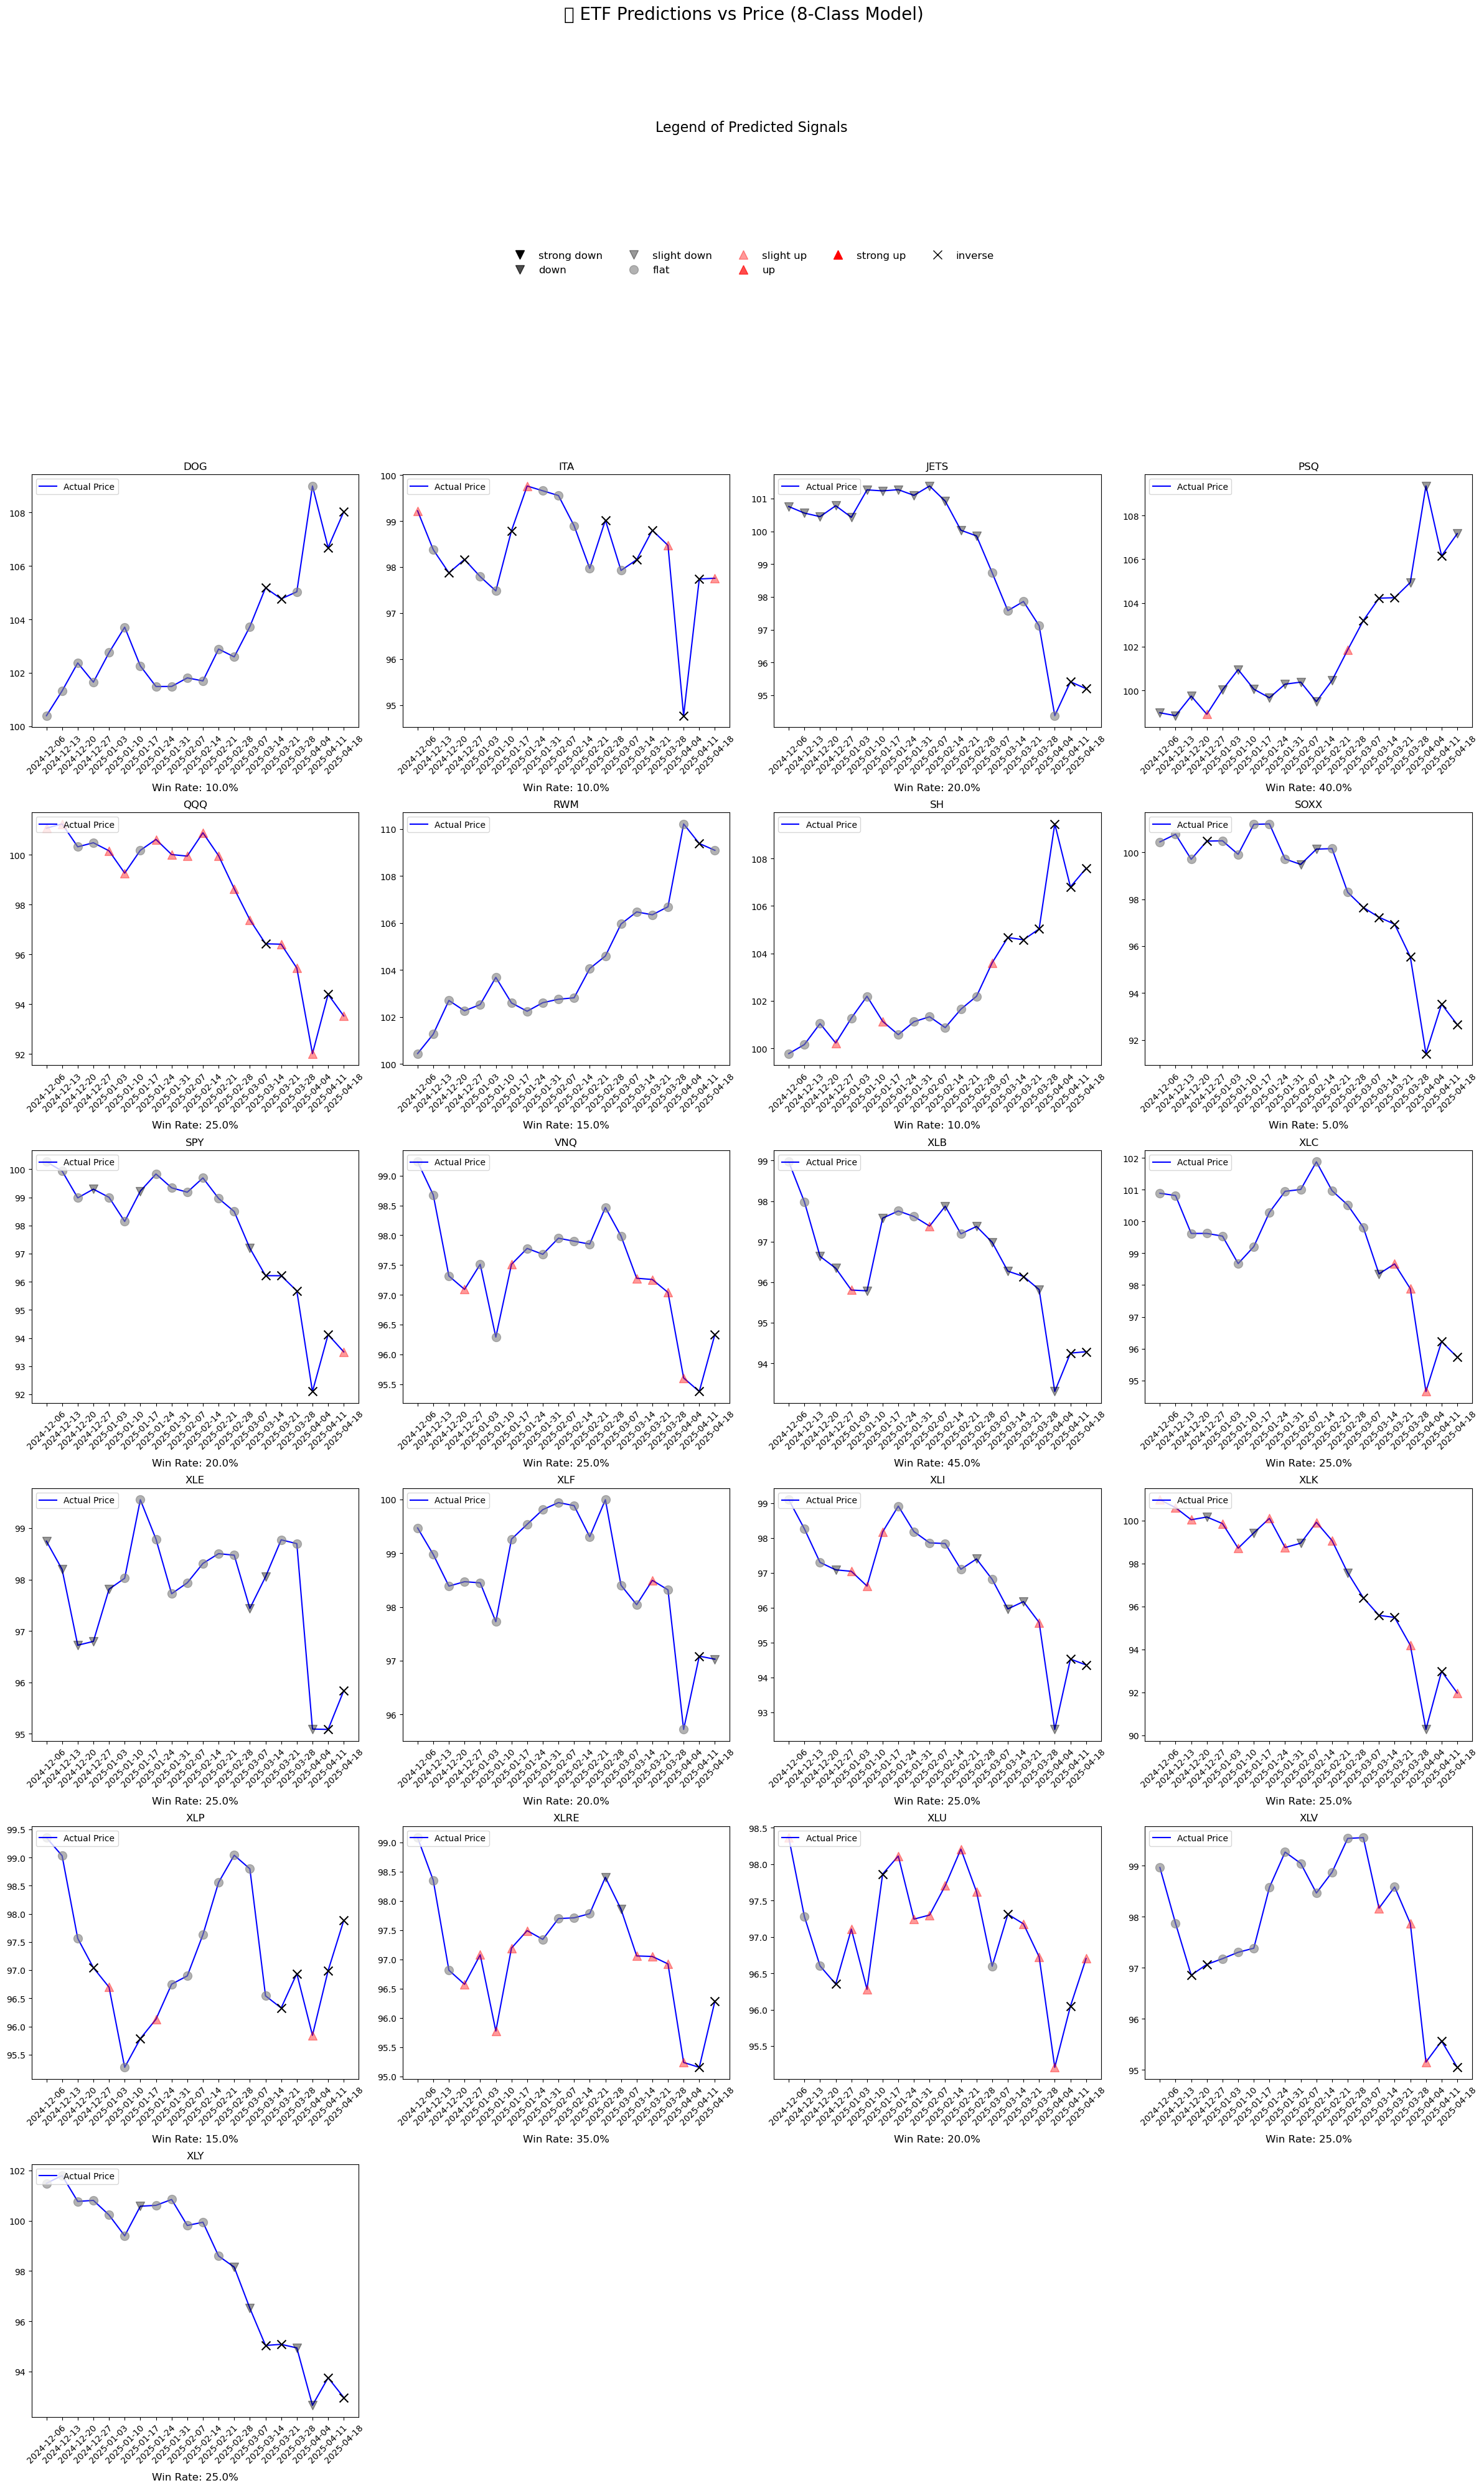

In [14]:
# plot showing cell (8-class)

import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime

# === Paths ===
pred_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'predicted_vs_actual'))
result_files = sorted([f for f in os.listdir(pred_dir) if f.endswith('_class_pred_result.csv')])
etf_list = [f.replace('_class_pred_result.csv', '') for f in result_files]

# === Signal Mapping for 8-class
class_map = {
    "strong down":   (0, 'black', 1.0, 'v'),
    "down":          (1, 'black', 0.7, 'v'),
    "slight down":   (2, 'black', 0.4, 'v'),
    "flat":          (3, 'gray', 0.6, 'o'),
    "slight up":     (4, 'red',   0.4, '^'),
    "up":            (5, 'red',   0.7, '^'),
    "strong up":     (6, 'red',   1.0, '^'),
    "inverse":       (7, 'black', 1.0, 'x'),
}
inverse_class_map = {k: v[0] for k, v in class_map.items()}

# === Return Classifier for ground truth
def classify_return(ret):
    if ret <= -4:
        return 0
    elif ret <= -1:
        return 1
    elif ret <= -0.2:
        return 2
    elif ret <= 0.2:
        return 3
    elif ret <= 1:
        return 4
    elif ret <= 4:
        return 5
    else:
        return 6

def classify_win(pred_class, true_class):
    up_set = {4, 5, 6}
    down_set = {0, 1, 2}
    if pred_class in up_set and true_class in up_set:
        return 1
    if pred_class in down_set and true_class in down_set:
        return 1
    if pred_class == 3 and true_class == 3:
        return 1
    if pred_class == 7 and true_class == 7:
        return 1
    return 0

# === Plot Setup
rows = (len(etf_list) + 3) // 4
fig = plt.figure(figsize=(24, 6 + 6 * rows))
gs = gridspec.GridSpec(rows + 1, 4, figure=fig)

# === Legend Plot
legend_ax = fig.add_subplot(gs[0, :])
legend_ax.axis('off')
legend_items = [
    plt.Line2D([0], [0], marker=shape, color='w', label=label,
               markerfacecolor=color if shape != 'x' else 'none',
               markeredgecolor=color, alpha=alpha, markersize=10)
    for label, (_, color, alpha, shape) in class_map.items()
]
legend_ax.legend(handles=legend_items, loc='center', ncol=5, fontsize=12, frameon=False)
legend_ax.set_title("Legend of Predicted Signals", fontsize=16)

# === ETF Plots
for idx, etf in enumerate(etf_list):
    try:
        path = os.path.join(pred_dir, f"{etf}_class_pred_result.csv")
        df = pd.read_csv(path)
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.dropna(subset=['Date', 'Predicted_Signal', 'ret_t+1'])

        df_show = df.tail(21).copy().reset_index(drop=True)
        shifted_returns = df_show['ret_t+1'].shift(-1)
        true_classes = shifted_returns.apply(classify_return).tolist()
        pred_classes = df_show['Predicted_Signal'].map(inverse_class_map).tolist()

        df_show = df_show.iloc[:-1]
        true_classes = true_classes[:-1]
        pred_classes = pred_classes[:-1]

        # Compute actual price line
        price_line = [100]
        for ret in df_show['ret_t+1']:
            price_line.append(price_line[-1] * (1 + ret / 100))
        df_show['Actual_Price'] = price_line[1:]

        win_flags = [classify_win(p, t) for p, t in zip(pred_classes, true_classes)]
        win_rate = sum(win_flags) / len(win_flags) if win_flags else 0

        row_idx = (idx // 4) + 1
        col_idx = idx % 4
        ax = fig.add_subplot(gs[row_idx, col_idx])
        ax.plot(df_show['Date'], df_show['Actual_Price'], color='blue', label='Actual Price')

        for i, row in df_show.iterrows():
            label = row['Predicted_Signal']
            if label not in class_map: continue
            _, color, alpha, marker = class_map[label]
            ax.scatter(row['Date'], row['Actual_Price'],
                       color=color if marker != 'x' else 'black',
                       marker=marker, alpha=alpha,
                       edgecolor=color, s=100, zorder=5)

        ax.set_title(etf)
        ax.set_xticks(df_show['Date'])
        ax.tick_params(axis='x', rotation=45)
        ax.text(0.5, -0.25, f"Win Rate: {win_rate * 100:.1f}%", 
                transform=ax.transAxes, ha='center', fontsize=12)
        ax.legend(loc='upper left')

    except Exception as e:
        print(f"⚠️ Failed to plot {etf}: {e}")

fig.suptitle("📊 ETF Predictions vs Price (8-Class Model)", fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


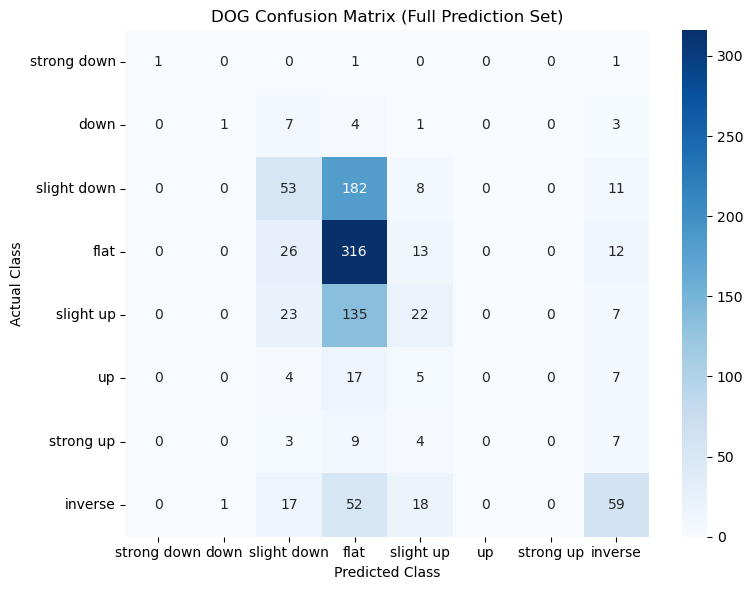

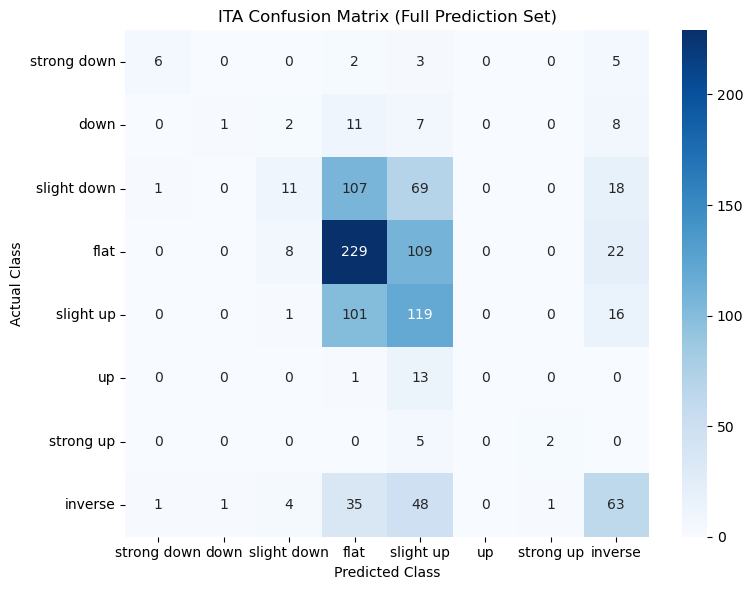

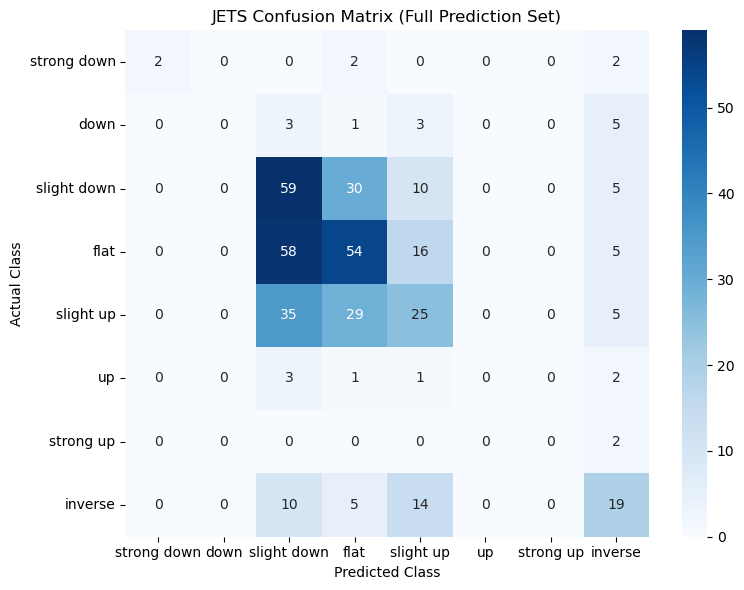

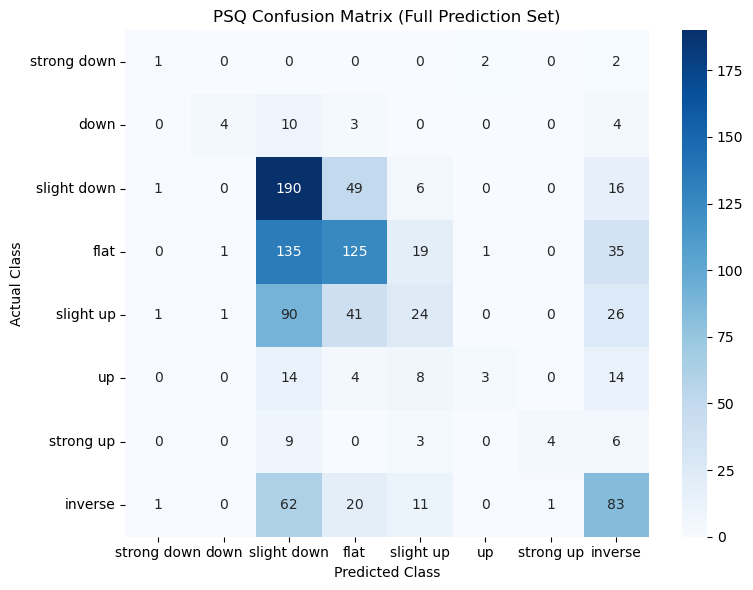

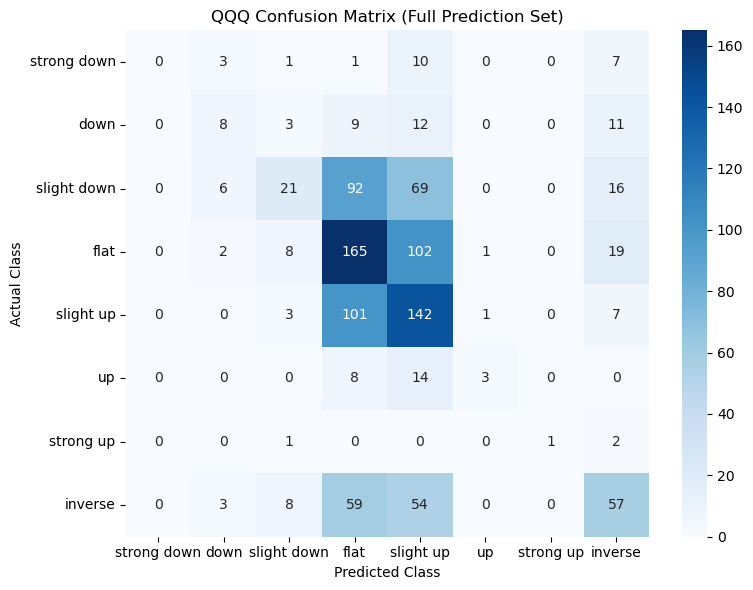

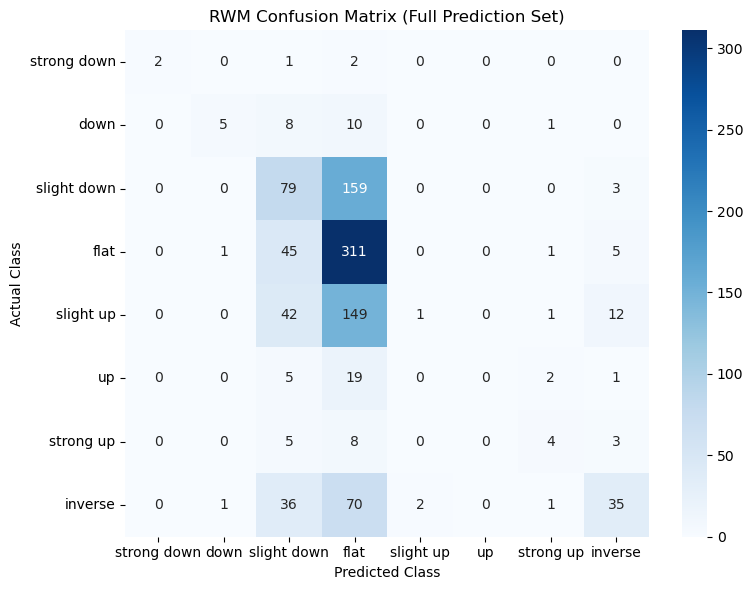

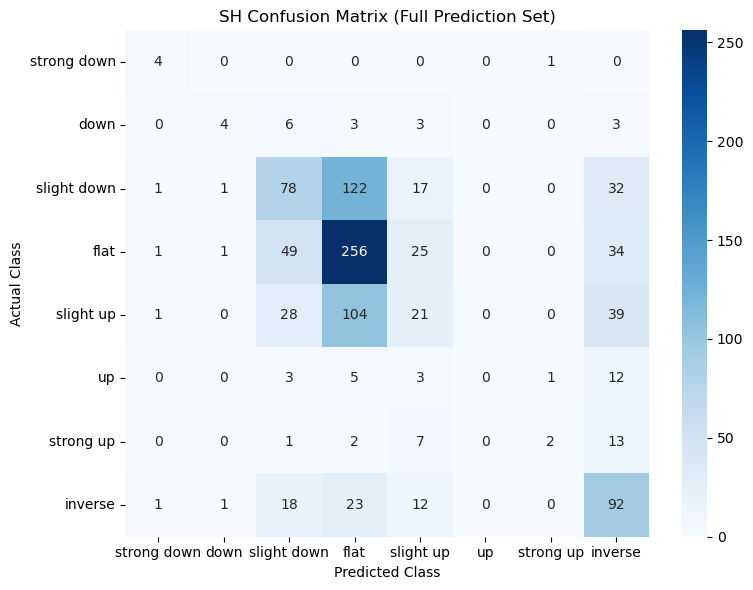

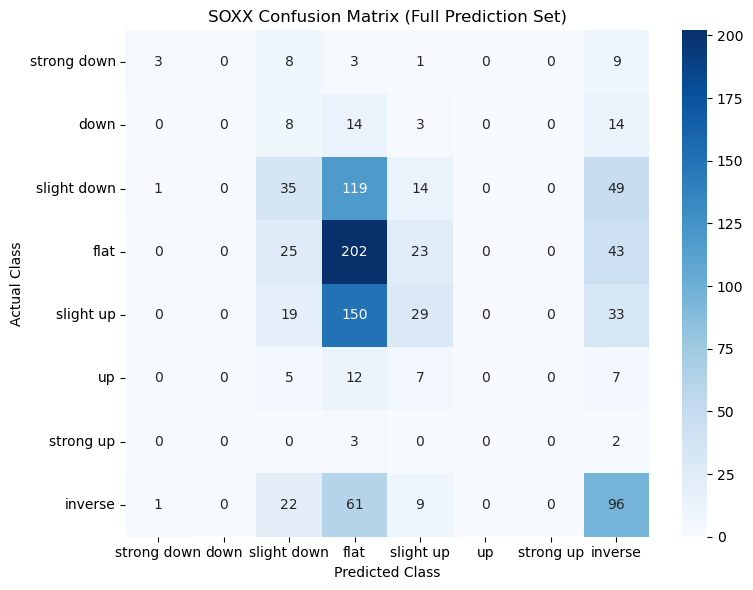

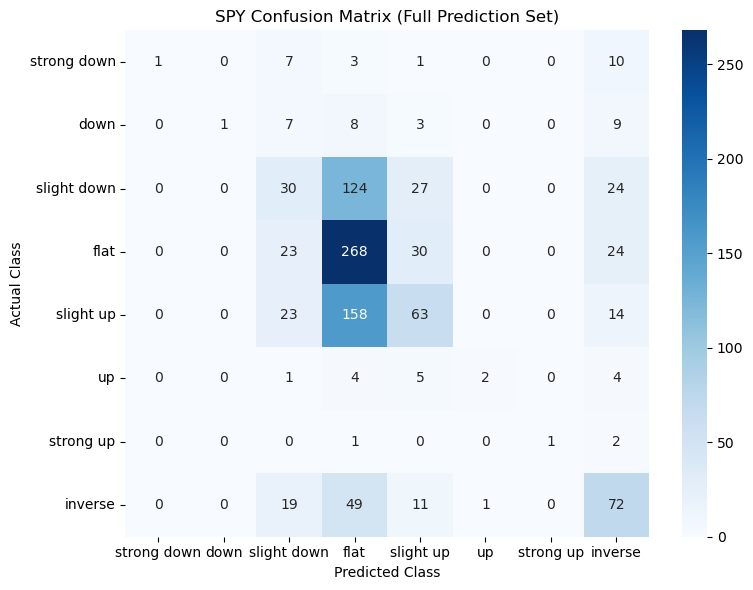

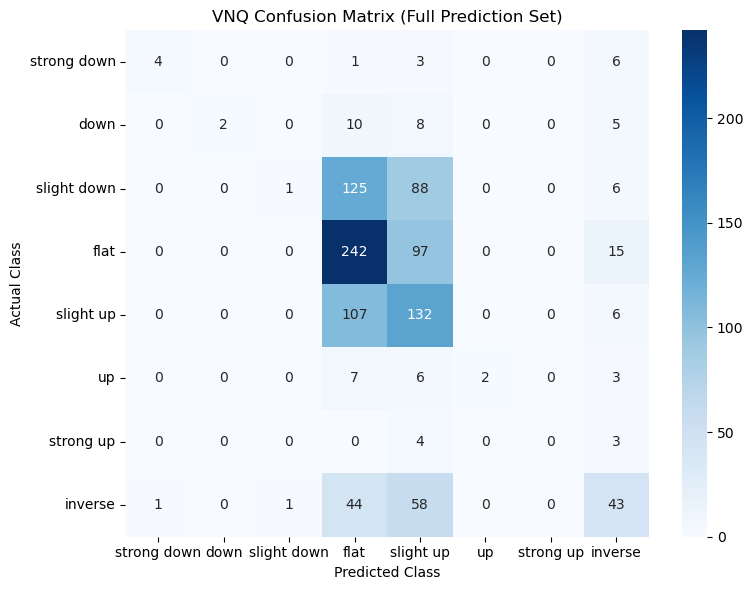

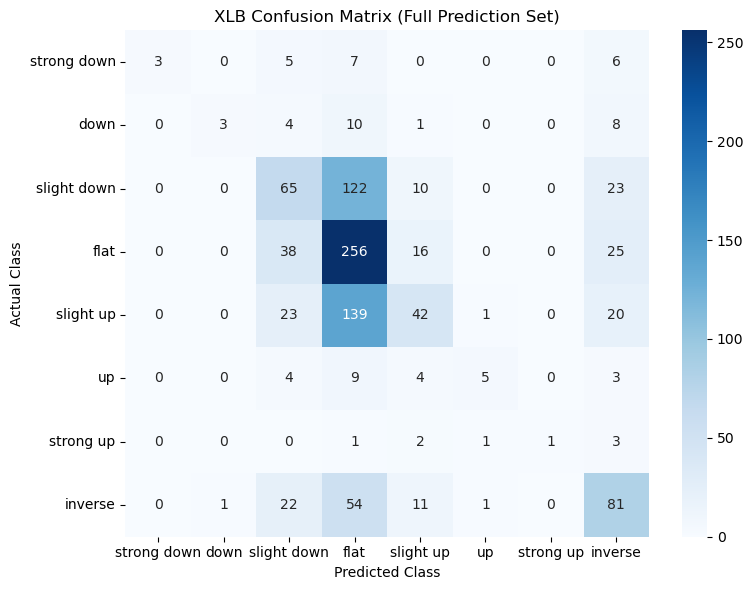

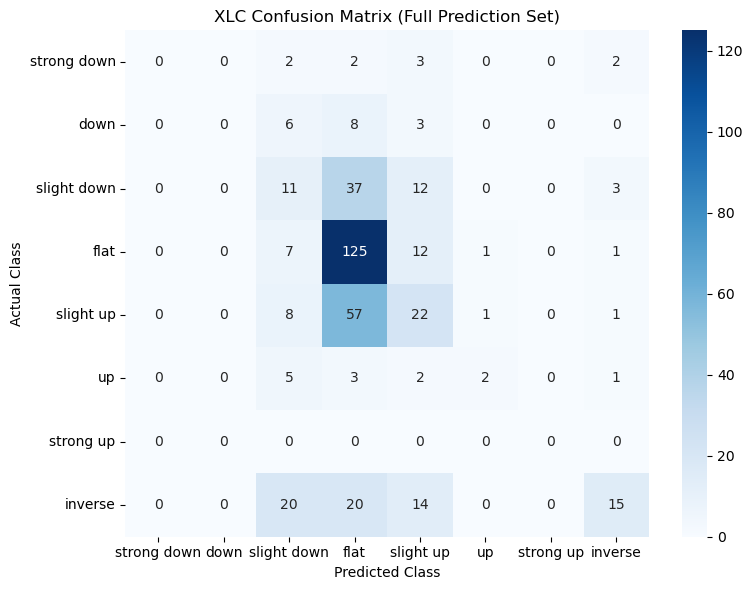

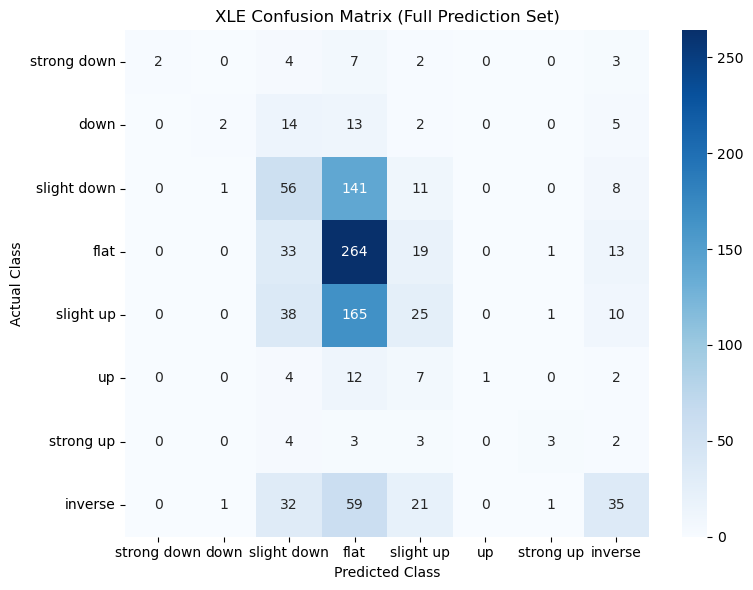

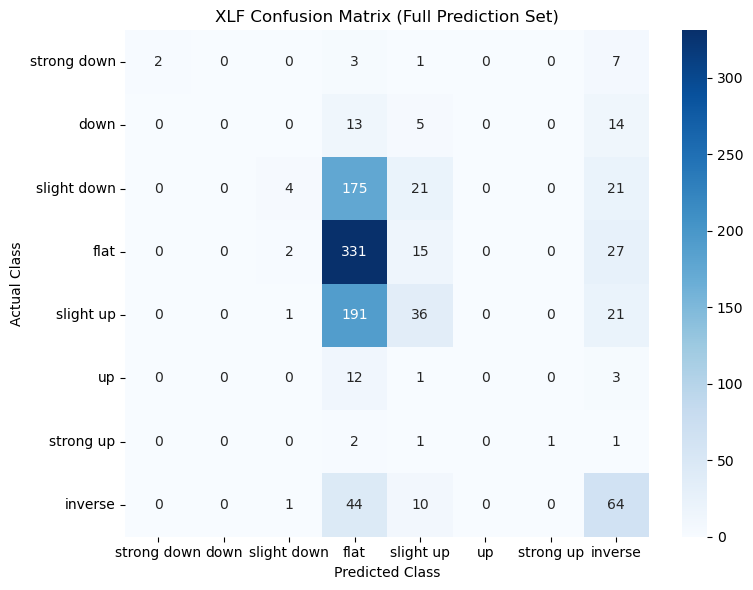

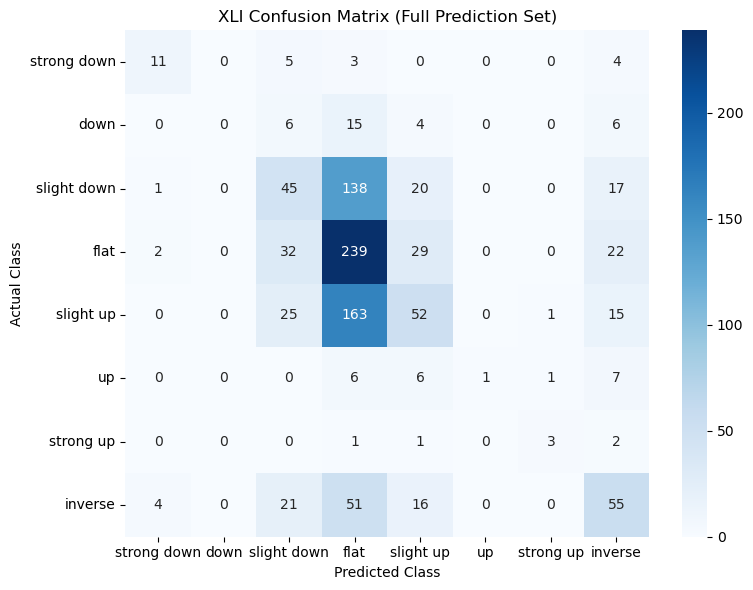

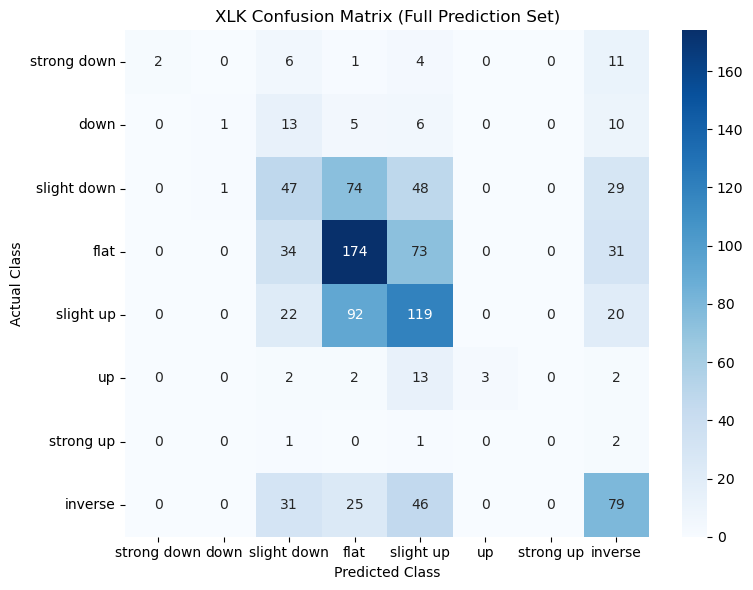

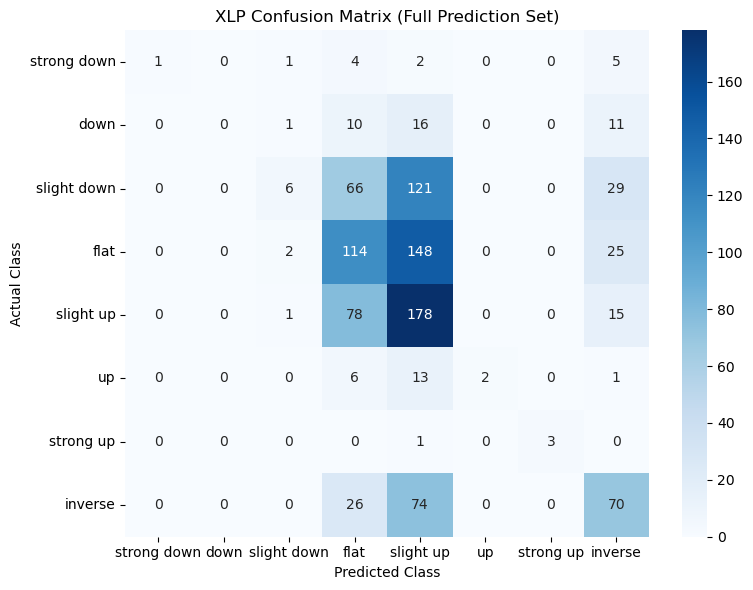

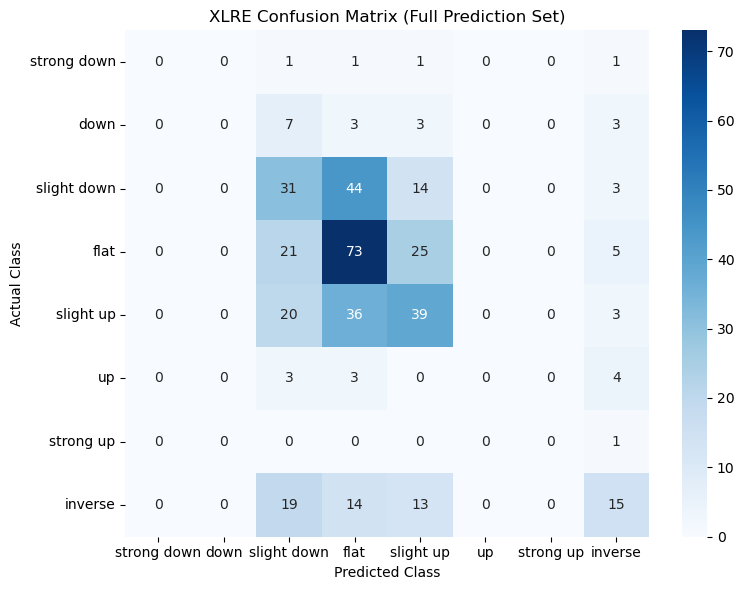

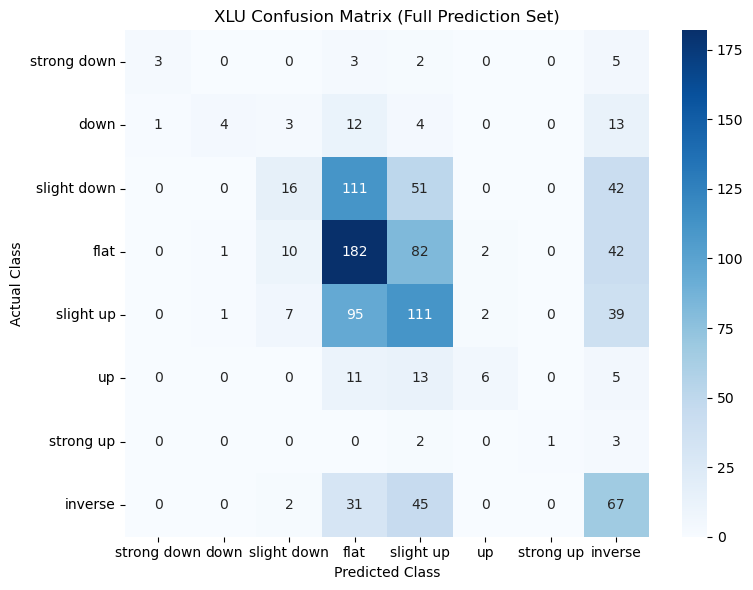

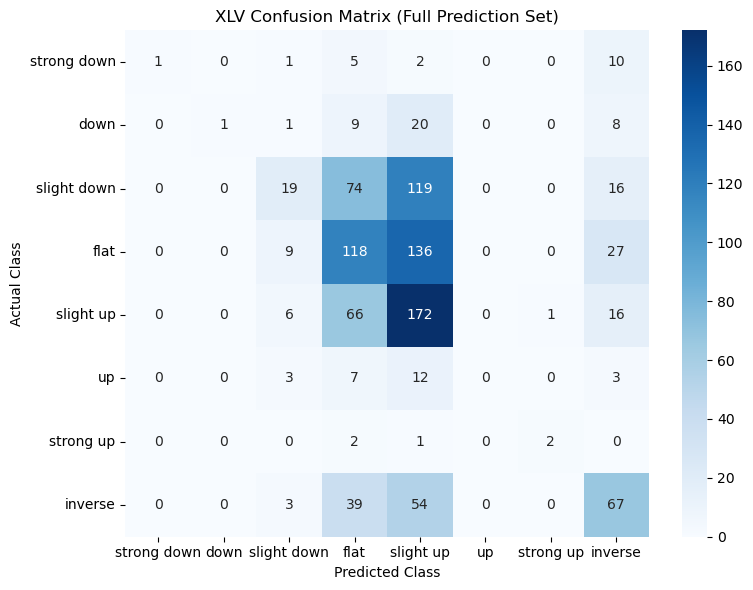

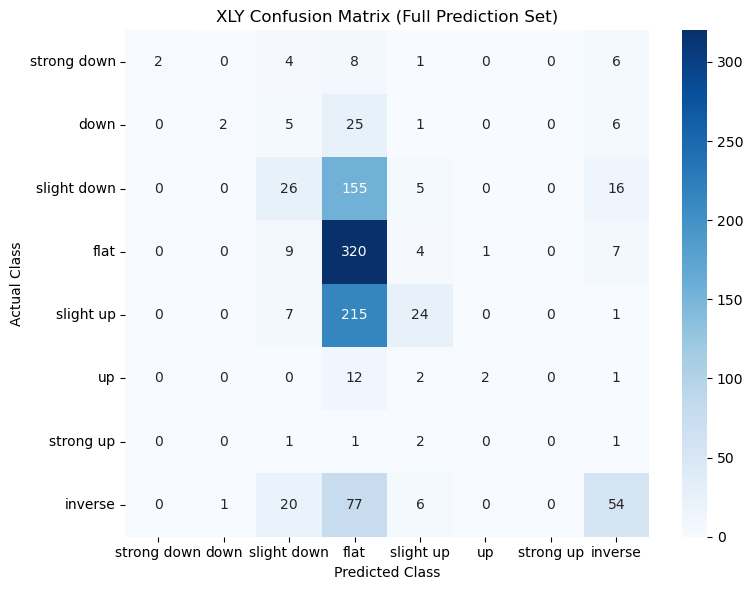

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# === Paths
pred_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'predicted_vs_actual'))
result_files = sorted([f for f in os.listdir(pred_dir) if f.endswith('_class_pred_result.csv')])
etf_list = [f.replace('_class_pred_result.csv', '') for f in result_files]

# === Class label mapping (8-class)
class_labels = [
    'strong down', 'down', 'slight down', 'flat',
    'slight up', 'up', 'strong up', 'inverse'
]
label_to_idx = {name: i for i, name in enumerate(class_labels)}

# === Confusion matrix plotting
def plot_conf_matrix(etf, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(8)))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"{etf} Confusion Matrix (Full Prediction Set)")
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.tight_layout()
    plt.show()

# === Loop through each ETF and compute confusion matrix
for etf in etf_list:
    try:
        path = os.path.join(pred_dir, f"{etf}_class_pred_result.csv")
        df = pd.read_csv(path)
        df = df.dropna(subset=['Predicted_Class', 'ret_t', 'ret_t+1'])

        # Ground truth from return data
        y_true = [classify_8class(rt, rt1) for rt, rt1 in zip(df['ret_t'], df['ret_t+1'])]
        y_pred = df['Predicted_Class'].astype(int).tolist()

        plot_conf_matrix(etf, y_true, y_pred)

    except Exception as e:
        print(f"⚠️ Failed on {etf}: {e}")


In [9]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error

# === Paths ===
pred_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'predicted_vs_actual'))
result_files = sorted([f for f in os.listdir(pred_dir) if f.endswith('_pred_result.csv')])
etf_list = [f.replace('_pred_result.csv', '') for f in result_files]

# === Metric containers
mae_dict = {}
win_rate_dict = {}

# === Compute MAE and direction accuracy
for etf in etf_list:
    try:
        df = pd.read_csv(os.path.join(pred_dir, f"{etf}_pred_result.csv"))
        df['Actual_Price'] = pd.to_numeric(df['Actual_Price'], errors='coerce')
        df['Predicted_Price'] = pd.to_numeric(df['Predicted_Price'], errors='coerce')
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df.dropna(subset=['Actual_Price', 'Predicted_Price', 'Date'], inplace=True)
        df.set_index('Date', inplace=True)

        # Calculate weekly return (percentage) for direction comparison
        actual_return = df['Actual_Price'].pct_change().dropna()
        predicted_return = df['Predicted_Price'].pct_change().dropna()

        aligned_index = actual_return.index.intersection(predicted_return.index)
        win_rate = (np.sign(actual_return.loc[aligned_index]) == np.sign(predicted_return.loc[aligned_index])).mean()
        mae = mean_absolute_error(df['Actual_Price'].loc[aligned_index], df['Predicted_Price'].loc[aligned_index])

        win_rate_dict[etf] = win_rate
        mae_dict[etf] = mae

    except Exception as e:
        print(f"⚠️ Error processing {etf}: {e}")
        continue

# === Create DataFrames for Heatmap
heatmap_df = pd.DataFrame({
    'WinRate': win_rate_dict,
    'MAE': mae_dict
}).T  # T to make ETFs columns

# === Normalize MAE for coloring (invert so higher = better)
normalized_mae = 1 - (heatmap_df.loc['MAE'] / heatmap_df.loc['MAE'].max())
heatmap_values = pd.DataFrame({
    'WinRate': heatmap_df.loc['WinRate'],
    '1 - Normalized MAE': normalized_mae
}).T

# === Plot
plt.figure(figsize=(len(etf_list)*0.6 + 4, 4))
sns.heatmap(heatmap_values, annot=True, fmt=".2f", cmap='YlGnBu', cbar_kws={'label': 'Score'})
plt.title("📊 ETF Prediction Accuracy (Win Rate & MAE Inversion)")
plt.xlabel("ETF Ticker")
plt.ylabel("Metric")
plt.tight_layout()
plt.show()


⚠️ Error processing DOG_class: 'Actual_Price'
⚠️ Error processing ITA_class: 'Actual_Price'
⚠️ Error processing JETS_class: 'Actual_Price'
⚠️ Error processing PSQ_class: 'Actual_Price'
⚠️ Error processing QQQ_class: 'Actual_Price'
⚠️ Error processing RWM_class: 'Actual_Price'
⚠️ Error processing SH_class: 'Actual_Price'
⚠️ Error processing SOXX_class: 'Actual_Price'
⚠️ Error processing SPY_class: 'Actual_Price'
⚠️ Error processing VNQ_class: 'Actual_Price'
⚠️ Error processing XLB_class: 'Actual_Price'
⚠️ Error processing XLC_class: 'Actual_Price'
⚠️ Error processing XLE_class: 'Actual_Price'
⚠️ Error processing XLF_class: 'Actual_Price'
⚠️ Error processing XLI_class: 'Actual_Price'
⚠️ Error processing XLK_class: 'Actual_Price'
⚠️ Error processing XLP_class: 'Actual_Price'
⚠️ Error processing XLRE_class: 'Actual_Price'
⚠️ Error processing XLU_class: 'Actual_Price'
⚠️ Error processing XLV_class: 'Actual_Price'
⚠️ Error processing XLY_class: 'Actual_Price'


ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1660x400 with 0 Axes>

In [ ]:
#heatmap

import os
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# === Paths ===
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'normalized_matrix'))
model_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'model_weights'))

# === ETF list ===
etf_list = [f.replace('_combined.csv', '') for f in os.listdir(data_dir) if f.endswith('_combined.csv')]

# === Heatmap Data ===
heatmap_data = {}

for etf in etf_list:
    try:
        feat_path = os.path.join(data_dir, f"{etf}_combined.csv")
        df_feat = pd.read_csv(feat_path, index_col=0)
        df_feat = df_feat.drop(columns='price') if 'price' in df_feat.columns else df_feat
        feature_names = df_feat.columns.tolist()
        
        # Try loading the top model weights
        weight_path = os.path.join(model_dir, f"{etf}_top1.pt")
        if not os.path.exists(weight_path):
            continue

        checkpoint = torch.load(weight_path, map_location='cpu')
        weights = checkpoint['weights']
        time_weights = weights['time_weights'].cpu().numpy()
        time_weights = torch.softmax(torch.tensor(time_weights), dim=0).numpy()

        weight_by_feature = np.array([time_weights[i] for i in range(len(time_weights))])
        weighted_importance = np.dot(time_weights, np.ones(len(feature_names)))  # uniform as placeholder
        
        heatmap_data[etf] = weighted_importance * np.ones(len(feature_names))

    except Exception as e:
        print(f"⚠️ Skipped {etf}: {e}")

# === Plot Heatmap ===
if heatmap_data:
    heatmap_df = pd.DataFrame(heatmap_data, index=feature_names)
    plt.figure(figsize=(16, 10))
    sns.heatmap(heatmap_df, cmap="magma", annot=False, fmt=".2f", linewidths=0.3)
    plt.title("🧠 Attention Weights (Averaged over Time) across ETFs")
    plt.xlabel("ETF")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()
else:
    print("❌ No heatmap data available.")


In [ ]:
import os
import pandas as pd
import torch
import numpy as np
from datetime import datetime, timedelta

# === Prediction Class ===
class WeeklyETFPredictor:
    def __init__(self, model_dir, data_dir, record_dir, price_path, device=None):
        self.model_dir = model_dir
        self.data_dir = data_dir
        self.record_dir = record_dir
        self.price_path = price_path
        os.makedirs(self.record_dir, exist_ok=True)
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def predict(self):
        # Get the nearest past Monday — this represents the start of the prediction week
        today = datetime.today()
        days_back = today.weekday() % 7
        monday = today - timedelta(days=days_back)
        monday_dt = pd.to_datetime(monday.strftime("%Y-%m-%d"))
        date_str = monday_dt.strftime("%Y-%m-%d")

        # Load ETF price data for reference
        price_df = pd.read_csv(
            self.price_path,
            index_col=0,
            parse_dates=True,
            date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d", errors='coerce')
        )
        price_df = price_df[price_df.index.notna()]
        price_df = price_df[~price_df.index.duplicated()].sort_index()

        print(f"🔍 Checking last available price dates: {price_df.index[-5:].to_list()}")
        print(f"📅 Using feature/price data for week starting on: {monday_dt.date()}")

        summary = []

        for fname in os.listdir(self.data_dir):
            if not fname.endswith("_combined.csv"):
                continue

            etf = fname.replace("_combined.csv", "")
            feat_path = os.path.join(self.data_dir, f"{etf}_combined.csv")
            mask_path = os.path.join(self.data_dir, f"{etf}_mask.csv")

            try:
                df_feat = pd.read_csv(feat_path, index_col=0, parse_dates=True)
                df_mask = pd.read_csv(mask_path, index_col=0, parse_dates=True)
            except Exception as e:
                print(f"❌ Error loading data for {etf}: {e}")
                continue

            if monday_dt not in df_feat.index:
                print(f"⚠️ No feature data for {etf} on {monday_dt.date()}")
                continue

            if etf not in price_df.columns or monday_dt not in price_df.index:
                print(f"⚠️ Price info missing for {etf} on {monday_dt.date()}")
                continue

            try:
                # Collect last 4 weeks (or pad if at beginning)
                idx_pos = df_feat.index.get_loc(monday_dt)
                if idx_pos < 3:
                    # Pad beginning if not enough data
                    x_real = df_feat.iloc[[0]* (4 - idx_pos) + list(range(idx_pos + 1))].values
                    x_mask = df_mask.iloc[[0]* (4 - idx_pos) + list(range(idx_pos + 1))].values
                else:
                    x_real = df_feat.iloc[idx_pos-3:idx_pos+1].values
                    x_mask = df_mask.iloc[idx_pos-3:idx_pos+1].values
                
                # Final tensor format: [1, 4, num_features]
                x_real = torch.tensor(x_real.astype(np.float32)).unsqueeze(0).to(self.device)
                x_mask = torch.tensor(x_mask.astype(np.float32)).unsqueeze(0).to(self.device)

                price = float(price_df.loc[monday_dt, etf])
            except Exception as e:
                print(f"❌ Tensor prep or price parse failed for {etf}: {e}")
                continue

            scores, preds, maes, winrates = [], [], [], []
            for i in range(1, 6):
                path = os.path.join(self.model_dir, f"{etf}_top{i}.pt")
                if not os.path.exists(path): continue

                try:
                    checkpoint = torch.load(path, map_location=self.device)
                    model = DualTransformerModel(num_features=x_real.shape[-1]).to(self.device)
                    model.load_state_dict(checkpoint['weights'])
                    model.eval()
                    with torch.no_grad():
                        pred = model(x_real, x_mask).item()
                    preds.append(pred)
                    maes.append(checkpoint['mae'])
                    winrates.append(checkpoint['win_rate'])
                    scores.append(checkpoint['weight'])
                except Exception as e:
                    print(f"❌ Model predict error for {etf} top{i}: {e}")

            if len(preds) == 0:
                continue

            pred_return = sum(p * w for p, w in zip(preds, scores))
            avg_mae = sum(maes) / len(maes)
            avg_win = sum(winrates) / len(winrates)

            if pred_return >= 0:
                target_up = round(price * (1 + pred_return / 100 + pred_return * avg_mae / 100), 2)
                stop_down = round(price * (1 - pred_return * avg_mae / 100), 2)
                buy_price = round(price, 2)
            else:
                target_up = stop_down = buy_price = "X"

            summary.append({
                'ETF': etf,
                'PredictedReturn': round(pred_return, 4),
                'MAE': round(avg_mae, 4),
                'WinRate': round(avg_win, 4),
                'BuyPrice': buy_price,
                'Target↑': target_up,
                'Stop↓': stop_down
            })

        summary_df = pd.DataFrame(summary)
        if summary_df.empty:
            print(f"⚠️ No valid predictions generated for {date_str}")
            return summary_df

        summary_df = summary_df.sort_values(by='PredictedReturn', ascending=False)

        # === Output
        print(f"\n📊 Weekly ETF Prediction Summary for {date_str}:")
        print(summary_df.to_string(index=False))

        output_path = os.path.join(self.record_dir, f"{date_str}_predict_record.csv")
        summary_df.to_csv(output_path, index=False)
        print(f"📁 Saved prediction to: {output_path}")

        return summary_df

# === Usage
predictor = WeeklyETFPredictor(
    model_dir="../model_weights",
    data_dir="../dataset/normalized_matrix",
    record_dir="../dataset/predict_record",
    price_path="../dataset/etf_prices_weekly.csv"
)
predictor.predict()


In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === Config ===
weights_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'model_weights'))
feature_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'normalized_matrix'))
os.makedirs(weights_dir, exist_ok=True)

# === Load feature names from any example ETF
first_etf = etf_list[0]
example_path = os.path.join(feature_dir, f'{first_etf}_combined.csv')
example_features = pd.read_csv(example_path, index_col=0)
factor_names = example_features.columns.tolist()

# === Collect factor importance across ETFs
factor_weights = {}

for etf in etf_list:
    weights = []
    for i in range(1, 6):
        model_path = os.path.join(weights_dir, f"{etf}_top{i}.pt")
        if not os.path.exists(model_path):
            continue

        data = torch.load(model_path, map_location='cpu')
        linear_weights = data['weights'].get('output.weight', None)
        if linear_weights is None:
            print(f"⚠️ {etf}_top{i}.pt missing output.weight")
            continue

        linear_weights = linear_weights.squeeze().numpy()
        if len(linear_weights) != len(factor_names):
            print(f"⚠️ {etf}_top{i}.pt: weight dim {len(linear_weights)} != {len(factor_names)} features")
            continue

        weights.append(linear_weights * data.get('weight', 1.0))

    if weights:
        factor_weights[etf] = sum(weights)

# === Create heatmap DataFrame
weight_df = pd.DataFrame(factor_weights, index=factor_names).T

# === Normalize (optional)
weight_df = weight_df.div(weight_df.abs().max(axis=1), axis=0)

# === Plot
plt.figure(figsize=(14, 8))
sns.heatmap(weight_df, cmap="coolwarm", center=0, annot=False)
plt.title("🎯 Factor Importance per ETF (Weighted Top 5 Models)", fontsize=14)
plt.xlabel("Factors")
plt.ylabel("ETFs")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
import os
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings

warnings.filterwarnings("ignore", message=".*enable_nested_tensor.*")
warnings.filterwarnings("ignore", message=".*weights_only=False.*")

class ETFBacktester:
    def __init__(self, model_dir, data_dir, price_path, initial_cash=2000, benchmark_symbol='SPY', seq_len=4):
        self.model_dir = model_dir
        self.data_dir = data_dir
        self.price_path = price_path
        self.initial_cash = initial_cash
        self.benchmark_symbol = benchmark_symbol
        self.seq_len = seq_len
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def run(self):
        print("🔁 Loading price data...")
        price_df = pd.read_csv(self.price_path, index_col=0)
        price_df.index = pd.to_datetime(price_df.index, errors='coerce')
        price_df = price_df[price_df.index.notna()]
        price_df = price_df.apply(pd.to_numeric, errors='coerce')
        price_df = price_df[~price_df.index.duplicated()].sort_index()
        print(f"📈 Loaded price data with {len(price_df)} entries.")

        etf_list = [fname.replace('_combined.csv', '') for fname in os.listdir(self.data_dir) if fname.endswith('_combined.csv')]
        print(f"🔍 ETF list found: {etf_list}")

        cash = self.initial_cash
        holdings = {}
        portfolio_values = []
        benchmark_values = []
        dates = []
        trade_log = []
        value_log = []
        portfolio_changes = []

        for i in range(self.seq_len, len(price_df) - 1):
            date = price_df.index[i]
            prev_dates = price_df.index[i - self.seq_len:i]
            next_date = price_df.index[i + 1]
            print(f"\n📅 Processing week: {date.date()} -> {next_date.date()}")

            for etf, info in list(holdings.items()):
                if etf not in price_df.columns or next_date not in price_df.index:
                    continue
                try:
                    sell_price = float(price_df.loc[next_date, etf])
                except Exception:
                    continue
                shares = info['Shares']
                buy_price = info['BuyPrice']
                sell_value = shares * sell_price
                actual_return = (sell_price - buy_price) / buy_price
                predicted_return = info.get('PredictedReturn', None)
                cash += sell_value
                trade_log.append({
                    'Date': next_date.strftime('%Y-%m-%d'),
                    'ETF': etf,
                    'Action': 'Sell',
                    'Price': sell_price,
                    'Shares': shares,
                    'Value': sell_value,
                    'BuyPrice': buy_price,
                    'PredictedReturn': predicted_return,
                    'ActualReturn': actual_return * 100
                })
            holdings.clear()

            week_predictions = []
            for etf in etf_list:
                feat_path = os.path.join(self.data_dir, f"{etf}_combined.csv")
                mask_path = os.path.join(self.data_dir, f"{etf}_mask.csv")
                if not os.path.exists(feat_path) or not os.path.exists(mask_path):
                    continue

                feat_df = pd.read_csv(feat_path, index_col=0, parse_dates=True)
                mask_df = pd.read_csv(mask_path, index_col=0, parse_dates=True)

                if not all(d in feat_df.index for d in prev_dates):
                    continue

                x_seq = torch.tensor(feat_df.loc[prev_dates].values.astype(np.float32)).unsqueeze(0).to(self.device)
                x_mask = torch.tensor(mask_df.loc[prev_dates].values.astype(np.float32)).unsqueeze(0).to(self.device)

                scores, preds = [], []
                for j in range(1, 6):
                    model_path = os.path.join(self.model_dir, f"{etf}_top{j}.pt")
                    if not os.path.exists(model_path):
                        continue
                    checkpoint = torch.load(model_path, map_location=self.device)
                    model = DualTransformerModel(num_features=x_seq.shape[-1]).to(self.device)
                    model.load_state_dict(checkpoint['weights'])
                    model.eval()
                    with torch.no_grad():
                        pred = model(x_seq, x_mask).item()
                    preds.append(pred)
                    scores.append(checkpoint['weight'])

                if preds:
                    pred_return = sum(p * w for p, w in zip(preds, scores))
                    try:
                        price = float(price_df.loc[date, etf])
                    except Exception:
                        continue
                    if not np.isnan(price):
                        week_predictions.append({
                            'ETF': etf,
                            'BuyPrice': price,
                            'PredictedReturn': float(pred_return)
                        })

            week_predictions = sorted(week_predictions, key=lambda x: -x['PredictedReturn'])[:2]

            budget_per_etf = cash / 2
            for item in week_predictions:
                etf = item['ETF']
                price = item['BuyPrice']
                shares = int(budget_per_etf // price)
                cost = shares * price
                if shares <= 0 or cost > cash:
                    continue
                cash -= cost
                holdings[etf] = {'Shares': shares, 'BuyPrice': price, 'PredictedReturn': item['PredictedReturn']}
                trade_log.append({
                    'Date': date.strftime('%Y-%m-%d'),
                    'ETF': etf,
                    'Action': 'Buy',
                    'Price': price,
                    'Shares': shares,
                    'Value': cost,
                    'PredictedReturn': item['PredictedReturn']
                })

            value = cash
            for etf, info in holdings.items():
                try:
                    price = float(price_df.loc[next_date, etf])
                except Exception:
                    price = 0
                value += info['Shares'] * price

            prev_value = portfolio_values[-1] if portfolio_values else self.initial_cash
            change_pct = ((value - prev_value) / prev_value) * 100

            portfolio_values.append(value)
            portfolio_changes.append(change_pct)
            dates.append(next_date.strftime('%Y-%m-%d'))
            value_log.append({
                'Date': next_date.strftime('%Y-%m-%d'),
                'Value': value,
                'Cash': cash,
                'Change%': change_pct,
                'Holdings': {k: dict(v) for k, v in holdings.items()}
            })

            if self.benchmark_symbol in price_df.columns:
                base_price = price_df[self.benchmark_symbol].iloc[0]
                current_price = price_df.loc[next_date, self.benchmark_symbol]
                benchmark_values.append(self.initial_cash * (current_price / base_price))
            else:
                benchmark_values.append(value)

        result_df = pd.DataFrame({
            'Date': dates,
            'PortfolioValue': portfolio_values,
            'BenchmarkValue': benchmark_values,
            'PortfolioChange%': portfolio_changes
        })
        result_df['Date'] = pd.to_datetime(result_df['Date'], errors='coerce')
        result_df.set_index('Date', inplace=True)

        pd.DataFrame(trade_log).to_csv("../dataset/backtest_trade_log.csv", index=False)
        pd.DataFrame(value_log).to_csv("../dataset/backtest_value_log.csv", index=False)

        plt.figure(figsize=(12, 6))
        plt.plot(result_df['PortfolioValue'], label='Strategy Portfolio')
        plt.plot(result_df['BenchmarkValue'], label=f'{self.benchmark_symbol} Benchmark')
        plt.title("Backtest Result: Strategy vs. Benchmark")
        plt.ylabel("Portfolio Value (USD)")
        plt.xlabel("Date")
        xticks_idx = result_df.index[::52]
        xticks_labels = [d.strftime('%Y') for d in xticks_idx]
        plt.xticks(xticks_idx, xticks_labels)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(f"\n💰 Final Portfolio Value: ${result_df['PortfolioValue'].iloc[-1]:,.2f}")
        print(f"📈 Final Benchmark Value: ${result_df['BenchmarkValue'].iloc[-1]:,.2f}")
        print(f"🎯 Strategy Return: {((result_df['PortfolioValue'].iloc[-1] / self.initial_cash - 1) * 100):.2f}%")
        print(f"📊 Benchmark Return: {((result_df['BenchmarkValue'].iloc[-1] / self.initial_cash - 1) * 100):.2f}%")

        return result_df

# === Execute
backtester = ETFBacktester(
    model_dir="../model_weights",
    data_dir="../dataset/normalized_matrix",
    price_path="../dataset/etf_prices_weekly.csv",
    initial_cash=2000,
    benchmark_symbol="SPY",
    seq_len=4
)

result_df = backtester.run()  # ⬅️ THIS must be included!
